# P6 - Catégorisez automatiquement des questions

In [1]:
ALLFILES = True
SAMPLE = False

## Importation des librairies

In [2]:
# Librairies classiques
import pandas as pd
import numpy as np
import datetime
import pickle
import os
import re
from time import time

# Librairies graphiques
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Librairies de traitement de texte
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
# Méthodes d'import export
import pickle
from sklearn.externals import joblib
CT_DIR = '../autotag/save/'

def save_obj(obj, name):
    fn = CT_DIR + name + '.pkl'
    try:
        os.remove(fn)
    except OSError:
        pass
    with open(fn, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print(fn, 'saved')

def load_obj(name):
    with open(CT_DIR + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_sklearn_obj(obj, name):
    fn = CT_DIR + name + '.pkl'
    try:
        os.remove(fn)
    except OSError:
        pass
    joblib.dump(obj, fn)
    print(fn, 'saved')

def load_sklearn_obj(name):
    return joblib.load(CT_DIR + name + '.pkl')

## Récupération et visualisation des données

In [4]:
# Récupération du fichier
CT_DIR_DATA = 'C:/Work/OpenClassrooms/data/P6/'    
filename = 'QueryResults300k-'
df_csv = pd.read_csv(CT_DIR_DATA + filename + '01.csv')
print(df_csv.shape)

if ALLFILES:
    # Concaténation de toutes les données
    for i in range(2, 5):
        n = CT_DIR_DATA + filename + '%0*d' % (2, i) + '.csv'
        print('reading', n, '...')
        f = pd.read_csv(n)
        print('shape ', f.shape)
        df_csv = df_csv.append(f, ignore_index=True)
        # Il faut reindexer si on a concaténé les fichiers 
        df_csv.index = range(len(df_csv.index))
    print(df_csv.shape)

(41069, 4)
reading C:/Work/OpenClassrooms/data/P6/QueryResults300k-02.csv ...
shape  (50000, 4)
reading C:/Work/OpenClassrooms/data/P6/QueryResults300k-03.csv ...
shape  (50000, 4)
reading C:/Work/OpenClassrooms/data/P6/QueryResults300k-04.csv ...
shape  (50000, 4)
(191069, 4)


In [5]:
dataraw = df_csv
if SAMPLE:
    dataraw = df_csv.sample(5000)
    dataraw.index = range(len(dataraw.index))

dataraw.head()

,Id,Body,Title,Tags
0,4,<p>I want to use a track-bar to change a form'...,"While applying opacity to a form, should we us...",<c#><winforms><type-conversion><decimal><opacity>
1,6,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>
2,9,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>
3,11,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...
4,13,<p>Is there any standard way for a Web Server ...,Determine a User's Timezone,<javascript><html><browser><timezone><timezone...


In [6]:
dataraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191069 entries, 0 to 191068
Data columns (total 4 columns):
Id       191069 non-null int64
Body     191069 non-null object
Title    191069 non-null object
Tags     191069 non-null object
dtypes: int64(1), object(3)
memory usage: 5.8+ MB


In [7]:
dataraw.describe()

,Id
count,1.910690e+05
mean,6.085126e+05
std,3.200431e+05
min,4.000000e+00
25%,3.390630e+05
50%,6.230540e+05
75%,9.108540e+05
max,1.132508e+06


## Nettoyage

In [8]:
mystops = set(stopwords.words("english"))

### Title + Body

In [9]:
# Regardons un exemple
print(dataraw.Title[0])
print(dataraw.Body[0])

While applying opacity to a form, should we use a decimal or a double value?
<p>I want to use a track-bar to change a form's opacity.</p>

<p>This is my code:</p>

<pre><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>

<p>When I build the application, it gives the following error:</p>

<blockquote>
  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>
</blockquote>

<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>



D'après l'exemple ci-dessus on voit qu'il va falloir :

    -enlever les balises HTML

    -enlever les caractères spéciaux, mais pas tous car certains sont liés à une information importante comme par exemple le # de c# 

    -convertir le texte en minuscules

    -enlever les stopwords

    -extraire la racine des mots


In [10]:
# Transformation de la feature 'Body'
def body_to_words(value):
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(value, "lxml").get_text() 
    #
    # 2. Remove special characters
    letters_only = re.sub("[^a-zA-Z0-9#]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in mystops]
    # 
    # 5. Lemme
    porter = nltk.PorterStemmer()
    meaningful_words = [porter.stem(w) for w in meaningful_words]
    #
    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))   

In [11]:
# Exemple, on inclue le titre qui peut contenir des mots împortants
print(body_to_words(dataraw.Title[0] + ' ' + dataraw.Body[0]))

appli opac form use decim doubl valu want use track bar chang form opac code decim tran trackbar1 valu 5000 opac tran build applic give follow error cannot implicitli convert type decim doubl tri use tran doubl control work code work fine past vb net project


Voilà qui est mieux, on va maintenant appliquer ce nettoyage et créer une nouvelle feature

In [12]:
dataraw['TextCleaned'] = dataraw['Title'].apply(body_to_words) + ' ' + dataraw['Body'].apply(body_to_words)

### Tags

In [13]:
# Tout d'abord vérifions qu'il n'y a pas d'espace dans les tags
for t in dataraw['Tags']:
    if ' ' in t:
        print(t)

In [14]:
# Pas d'espace dans les tags, on va pouvoir les séparer de leur balise
def tag_to_words(value):
    # On sépare les tags des balises
    words = value.replace('><', ' ')
    words = words.replace('>', '')
    words = words.replace('<', '')
    
    # On converti en minuscule et on en fait un tableau
    tab_words = words.lower().split()                             

    # On enlève les stopwords
    meaningful_words = [w for w in tab_words if not w in mystops]

    # On retourne une chaine de mots
    return(" ".join(meaningful_words))

In [15]:
dataraw['TagsCleaned'] = dataraw['Tags'].apply(tag_to_words)

In [16]:
# Regardons ce que ça donne
dataraw['TagsCleaned'][:5]

0        c# winforms type-conversion decimal opacity
1                  html css css3 internet-explorer-7
2                                   c# .net datetime
3       c# datetime time datediff relative-time-span
4    javascript html browser timezone timezoneoffset
Name: TagsCleaned, dtype: object

In [17]:
# Combien de tags différents ?

all_tags = sorted(set(" ".join(t for t in dataraw['TagsCleaned']).split(' ')))

if '' in all_tags: all_tags.remove('')
if ' ' in all_tags: all_tags.remove(' ')

print('Il y a', str(len(all_tags)), 'tags différents, voilà les 20 premiers classés alphabétiquement :')
all_tags[:20]

Il y a 15077 tags différents, voilà les 20 premiers classés alphabétiquement :


['.bash-profile',
 '.doc',
 '.emf',
 '.htaccess',
 '.htpasswd',
 '.net',
 '.net-1.0',
 '.net-1.1',
 '.net-2.0',
 '.net-3.0',
 '.net-3.5',
 '.net-4.0',
 '.net-assembly',
 '.net-attributes',
 '.net-client-profile',
 '.net-core',
 '.net-framework-source',
 '.net-framework-version',
 '.net-internals',
 '.net-micro-framework']

In [18]:
# Regardons s'il y a des stopwords parmi les tags
#stoptag = []
#for t in all_tags:
#    if t in mystops:
#        stoptag.append(t)
#stoptag

In [19]:
# Et à quoi ils correspondent 
#for i, row in dataraw.iterrows():
#    tag_in_stop = False
#    for t in row['TagsCleaned'].split():
#        if t in stoptag:
#            print(row['Tags'])
#            break

In [20]:
# Regardons si le tag se retrouve toujours dans Title+Body
nb = 0
for i, row in dataraw.iterrows():
    tt = row['TagsCleaned'].split()
    tag_in_body = False
    for t in tt:
        if t in str.lower(row['Body']) or t in str.lower(row['Title']):
            tag_in_body = True
            break
        t = t.replace('-', ' ')
        if t in str.lower(row['Body']) or t in str.lower(row['Title']):
            tag_in_body = True
            break
    if not tag_in_body:
        nb += 1
        #print(tt)
        #if 'java' in tt:
        #    print(row['TagsCleaned'] + '\n' + row['Title'] + '\n' + row['Body'])
        #break
print(nb)
print(nb/dataraw.Tags.count()*100, "% du temps, aucun des tags ne provient du texte + titre de l'utilisateur")

19417
10.1622973899 % du temps, aucun des tags ne provient du texte + titre de l'utilisateur


## Word occurrence

In [21]:
# Méthode d'affichage des mots les plus utilisés

def word_occurrence(feature, top=20):
    count_keywords = dict()
    for row in feature:
        for word in row.split():
            if word in count_keywords:
                count_keywords[word] += 1
            else:
                count_keywords[word] = 1
    liste = []
    for k, v in count_keywords.items():
        liste.append([k,v])

    liste = sorted(liste, key=lambda x:x[1], reverse=True)
    print("Nombre de mots total : {} (pour {} lignes)".format(len(liste), feature.count()))

    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(10, .3*top))
    y_axis = [i[1] for i in liste[:top]]
    x_axis = [k for k,i in enumerate(liste[:top])]
    x_label = [i[0] for i in liste[:top]]
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    plt.yticks(x_axis, x_label)
    plt.xlabel("Nb. of occurences", fontsize=18, labelpad=10)
    ax.barh(x_axis, y_axis, align='center')
    ax = plt.gca()
    ax.invert_yaxis()

    plt.title("Words occurence : top"+str(top), bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
    plt.show()
    
    # On renvoie la liste triée par nombre d'occurrences
    return liste

Nombre de mots total : 15077 (pour 191069 lignes)


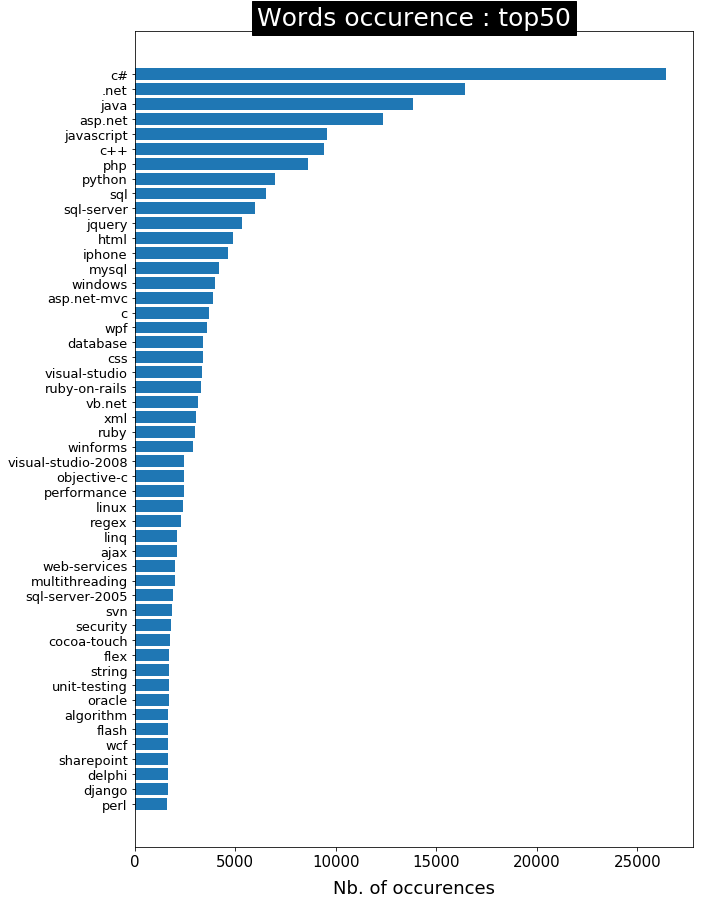

In [22]:
top_tags_sorted = word_occurrence(dataraw.TagsCleaned, top=50)

Nombre de mots total : 296928 (pour 191069 lignes)


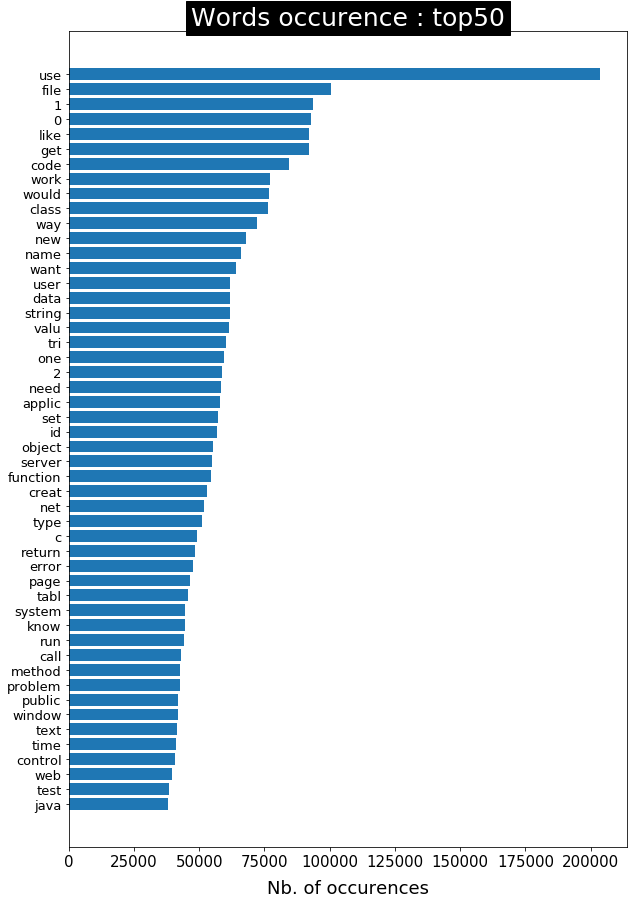

In [23]:
top_words_sorted = word_occurrence(dataraw.TextCleaned, top=50)

In [28]:
# On peut faire un peu plus de nettoyage, mais le paramètre max_df de la vectorisation devrait s'en charger
removelist = [t[0] for t in top_words_sorted[:10] if t[0] not in all_tags]
def cleantoplist(value):
    words = value.split()
    clean_words = [w for w in words if not w in removelist]
    return( " ".join( clean_words ))   

In [30]:
#dataraw['TextCleaned'] = dataraw['TextCleaned'].apply(cleantoplist)
#toplist = word_occurrence(dataraw.TextCleaned)

## Save

In [31]:
# Train set et test set

df = dataraw[['TextCleaned', 'TagsCleaned']]
len_train = int(len(df)*.8)
df_train = df[:len_train]
df_test = df[len_train:]

df_train.to_csv("../autotag/save/df_train.csv", index=False, encoding="utf_8")
df_test.to_csv("../autotag/save/df_test.csv", index=False, encoding="utf_8")

In [32]:
# Liste des tags triés par nombre d'apparition

save_obj(top_tags_sorted, 'top_tags')

../autotag/save/top_tags.pkl saved


In [33]:
# Exemple
top_tags_sorted[:10]

[['c#', 26446],
 ['.net', 16452],
 ['java', 13844],
 ['asp.net', 12347],
 ['javascript', 9584],
 ['c++', 9410],
 ['php', 8607],
 ['python', 6953],
 ['sql', 6542],
 ['sql-server', 5972]]

In [35]:
# Exemple
top_tags_sorted[490:500]

[['mercurial', 161],
 ['cmd', 161],
 ['calendar', 161],
 ['scroll', 161],
 ['postback', 160],
 ['usability', 159],
 ['internet-explorer-8', 159],
 ['initialization', 159],
 ['db2', 158],
 ['report', 158]]